In [ ]:
# ============================================================
# TASK 3 - OPTIMIZE
# ============================================================

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

np.random.seed(42)

TRAIN_PATH = "train.csv"
TEST_PATH  = "test.csv"
OUT_PATH   = "task3_submission.csv"

# ------------------------------
# 1) Load
# ------------------------------
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

TARGET = "spending_30d"
# find id column if present
id_col = None
for c in ["id", "player_id", "player", "uid"]:
    if c in train.columns:
        id_col = c
        break

print("Train:", train.shape, "Test:", test.shape, "id_col:", id_col)

Train: (104000, 35) Test: (25889, 34) id_col: id


In [ ]:
# ------------------------------
# 2) Quick EDA
# ------------------------------
print("Zeros in target:", (train[TARGET]==0).sum(), "/", len(train), "ratio:", (train[TARGET]==0).mean())

Zeros in target: 50132 / 104000 ratio: 0.4820384615384615


In [ ]:
# ------------------------------
# 3) Preprocessing
# ------------------------------
train_idx = len(train)
full = pd.concat([train.drop(columns=[TARGET]), test], ignore_index=True, sort=False)

if id_col and id_col in full.columns:
    full = full.drop(columns=[id_col])

# numeric / categorical separation
num_cols = full.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = full.select_dtypes(include=["object", "category"]).columns.tolist()

# fill numerics
for c in num_cols:
    if full[c].isnull().any():
        full[c] = full[c].fillna(full[c].median())

# encode categorical with LabelEncoder (tree models work well with label encoding)
for c in cat_cols:
    full[c] = full[c].astype(str).fillna("NA")
    le = LabelEncoder()
    full[c] = le.fit_transform(full[c])

# split back
X = full.iloc[:train_idx].reset_index(drop=True)
X_test = full.iloc[train_idx:].reset_index(drop=True)
y = train[TARGET].reset_index(drop=True)

In [ ]:
# ------------------------------
# 4) Two-stage CV training
# ------------------------------
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# LightGBM params
clf_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'n_estimators': 1000,
    'random_state': 42,
    'verbosity': -1
}
reg_params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'n_estimators': 1000,
    'random_state': 42,
    'verbosity': -1
}

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))

y_pos = (y > 0).astype(int)

for fold, (tr_idx, val_idx) in enumerate(kf.split(X), 1):
    print("Fold", fold)
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]
    y_tr_pos = y_pos.iloc[tr_idx]
    y_val_pos = y_pos.iloc[val_idx]

    # classifier
    clf = lgb.LGBMClassifier(**clf_params)
    clf.fit(X_tr, y_tr_pos)  # on full training rows (pos vs not)

    # regressor trained on positive target rows only
    pos_mask = y_tr > 0
    if pos_mask.sum() < 30:
        # fallback: train on all
        reg_X = X_tr
        reg_y = np.log1p(y_tr)
    else:
        reg_X = X_tr[pos_mask.values]
        reg_y = np.log1p(y_tr[pos_mask])

    reg = lgb.LGBMRegressor(**reg_params)
    reg.fit(reg_X, reg_y)

    val_prob = clf.predict_proba(X_val)[:,1]
    val_reg_log = reg.predict(X_val)
    val_reg_amt = np.expm1(val_reg_log)
    val_pred = val_prob * val_reg_amt

    oof_preds[val_idx] = val_pred

    # test predictions accumulate average across folds
    test_prob = clf.predict_proba(X_test)[:,1]
    test_reg_log = reg.predict(X_test)
    test_reg_amt = np.expm1(test_reg_log)
    test_preds += test_prob * test_reg_amt / n_splits

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


In [ ]:
# ------------------------------
# 5) CV evaluation
# ------------------------------
oof_mae = mean_absolute_error(y, oof_preds)
nmae = oof_mae / y.mean() if y.mean() != 0 else np.nan
print("OOF MAE:", oof_mae,  "\nOOF NMAE:", nmae)

OOF MAE: 2873.231539580671 
OOF NMAE: 0.27708277284994726


In [ ]:
# ------------------------------
# 6) Save submission file
# ------------------------------
if id_col and id_col in test.columns:
    submission = pd.DataFrame({id_col: test[id_col].values, "task3": test_preds})
else:
    submission = pd.DataFrame({"id": np.arange(1, len(test_preds)+1), "task3": test_preds})

submission.to_csv(OUT_PATH, index=False)
print("Saved submission to", OUT_PATH)

Saved submission to task3_submission.csv


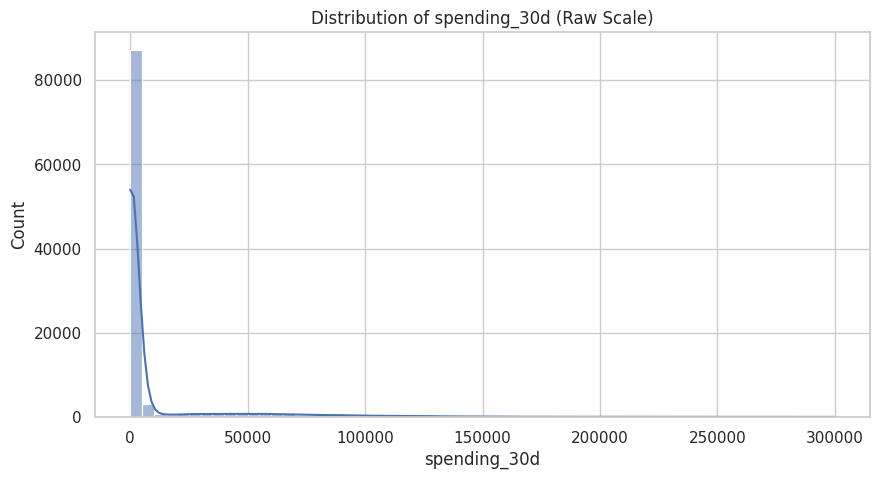

In [ ]:
# ============================================================
# VISUALIZATIONS FOR REPORT
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# ------------------------------
# 1) Target Distribution (Raw)
# ------------------------------
plt.figure(figsize=(10,5))
sns.histplot(y, bins=60, kde=True)
plt.title("Distribution of spending_30d (Raw Scale)")
plt.xlabel("spending_30d")
plt.ylabel("Count")
plt.show()

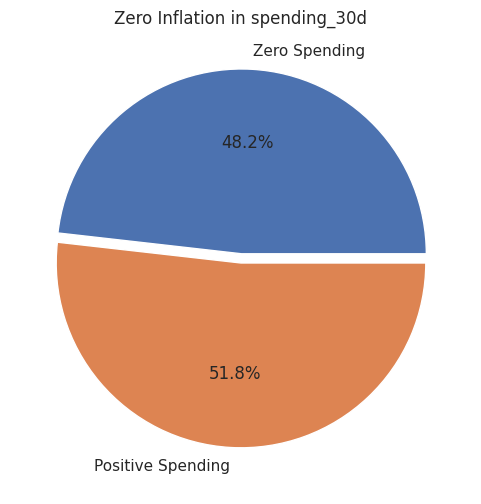

In [ ]:
# ------------------------------
# 2) Zero Inflation Visualization
# ------------------------------
zero = (y == 0).sum()
nonzero = (y > 0).sum()

plt.figure(figsize=(6,6))
plt.pie([zero, nonzero],
        labels=["Zero Spending", "Positive Spending"],
        autopct="%1.1f%%",
        explode=[0.05, 0])
plt.title("Zero Inflation in spending_30d")
plt.show()

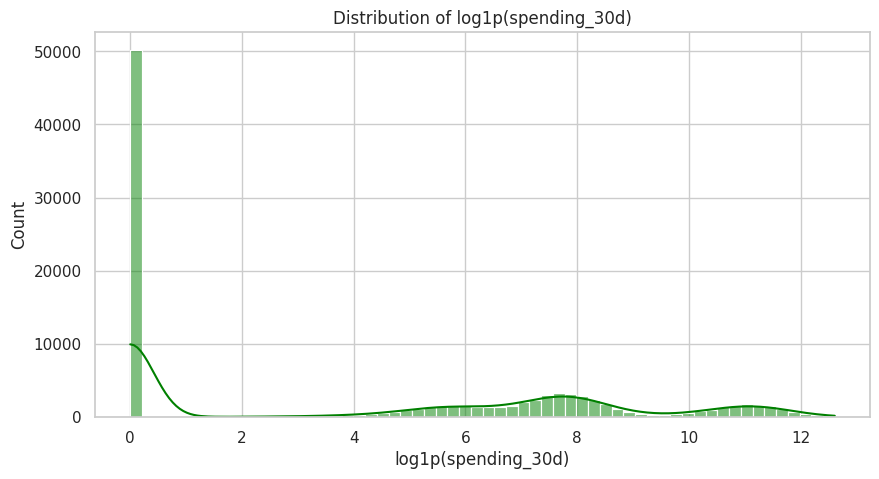

In [ ]:
# ------------------------------
# 3) Log-transform Distribution
# ------------------------------
import numpy as np
log_y = np.log1p(y)

plt.figure(figsize=(10,5))
sns.histplot(log_y, bins=60, kde=True, color="green")
plt.title("Distribution of log1p(spending_30d)")
plt.xlabel("log1p(spending_30d)")
plt.ylabel("Count")
plt.show()

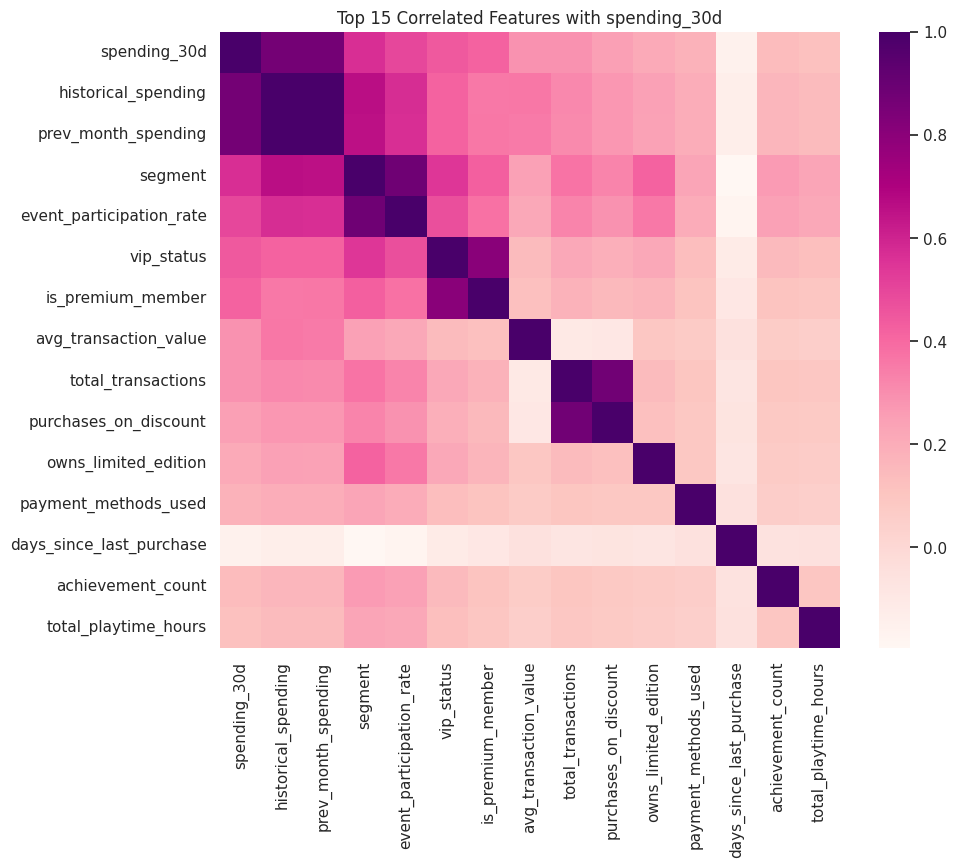

In [ ]:

# ------------------------------
# 4) Correlation Heatmap (Top 15)
# ------------------------------
num_cols = train.select_dtypes(include=['float64','int64']).columns.tolist()
corr = train[num_cols].corr()

top_corr = corr['spending_30d'].abs().sort_values(ascending=False).head(15).index

plt.figure(figsize=(10,8))
sns.heatmap(train[top_corr].corr(),
            cmap="RdPu",
            annot=False)
plt.title("Top 15 Correlated Features with spending_30d")
plt.show()

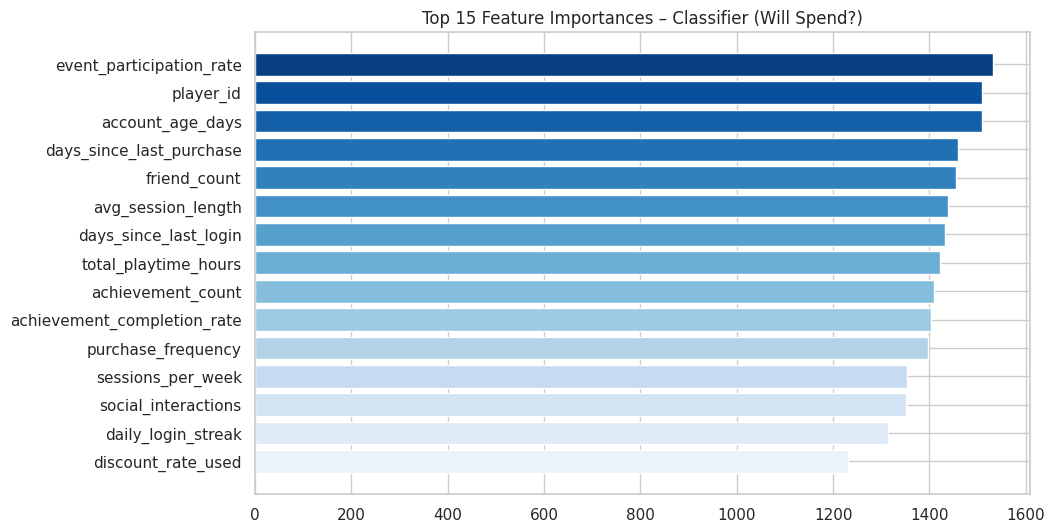

In [ ]:
# ------------------------------
# 5) Feature Importance (Classifier)
# ------------------------------
try:
    importances_clf = clf.feature_importances_
    features = X.columns

    idx = np.argsort(importances_clf)[-15:]

    plt.figure(figsize=(10,6))
    plt.barh(features[idx], importances_clf[idx],
         color=sns.color_palette("Blues", 15))
    plt.title("Top 15 Feature Importances – Classifier (Will Spend?)")
    plt.show()
except:
    print("Classifier not available for feature importance plot.")

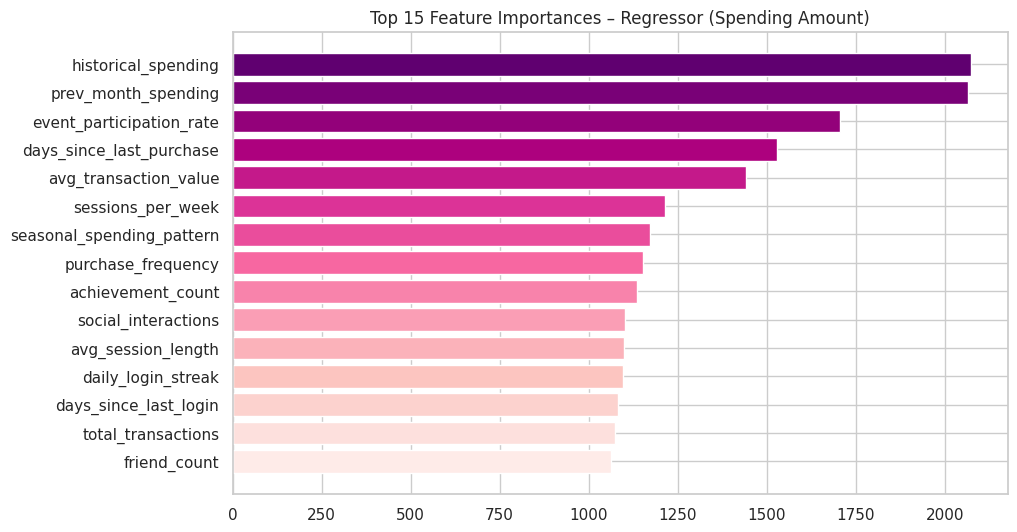

In [ ]:
# ------------------------------
# 6) Feature Importance (Regressor)
# ------------------------------
try:
    importances_reg = reg.feature_importances_
    features = X.columns

    idx = np.argsort(importances_reg)[-15:]

    plt.figure(figsize=(10,6))
    plt.barh(features[idx], importances_reg[idx],
         color=sns.color_palette("RdPu", 15))
    plt.title("Top 15 Feature Importances – Regressor (Spending Amount)")
    plt.show()
except:
    print("Regressor not available for feature importance plot.")

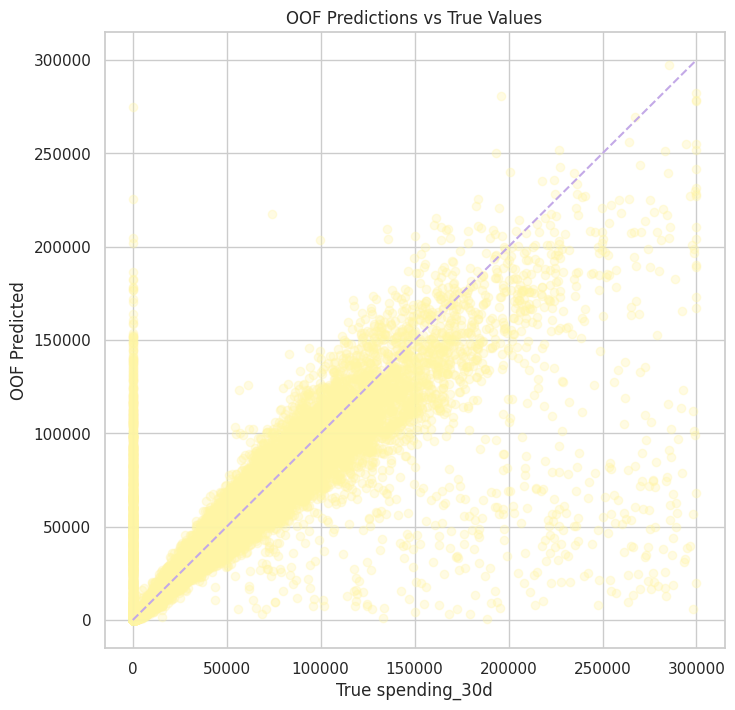

In [ ]:
# ------------------------------
# 7) OOF vs True Scatter Plot
# ------------------------------
plt.figure(figsize=(8,8))

# Scatter = Yellow pastel
plt.scatter(y, oof_preds,
            alpha=0.3,
            color="#FFF5A5")   # pastel yellow

# Reference line = Purple pastel
plt.plot([0, y.max()], [0, y.max()],
         linestyle='--',
         color="#C3A9E7")     # pastel purple

plt.xlabel("True spending_30d")
plt.ylabel("OOF Predicted")
plt.title("OOF Predictions vs True Values")
plt.show()
